# Plotting temperature and photosynthesis-related GO term counts, normalised by number of InterPro annotations, for Tara Oceans project ERP009703.


This task shows how to analysie metadata and annotations retrieved from the EMG API and combined on the fly to generate the visualisations.

In [2]:
from jsonapi_client import Session, Filter

metadata_key = 'temperature'
normilize_meta_key = 'Total InterProScan matches'

result = {}

with Session('https://www.ebi.ac.uk/metagenomics/api/v0.2/') as s:

    run_meta_mapping = {}
    missing_temp = list()
    
    print('Loading data from API.', end='', flush=True)
    # list samples
    f = Filter('study_accession=ERP009703')
    for anls in s.iterate('pipelines/4.0/analysis', f):
        print('.', end='', flush=True)
        for m in anls.sample.metadata:
            if m.var_name.lower() == metadata_key.lower():
                m_value = int(float(m.var_value))
                run_meta_mapping[anls.accession] = m_value
        # if missing
        try:
            run_meta_mapping[anls.accession]
        except KeyError:
            missing_temp.append(anls.accession)

        for _m in anls.metadata:
            if _m.var_name.lower() == normilize_meta_key.lower():
                ipr_count = _m.var_value

        _key = run_meta_mapping[anls.accession]
        try:
            result[_key]
        except KeyError:
            result[_key] = {}

        rt = "runs/%s/pipelines/%s/go-slim" % (anls.accession, anls.pipeline_version)
        _f = Filter('page_size=100')
        for a in s.iterate(rt, _f):
            try:
                result[_key][a.accession]
            except KeyError:
                result[_key][a.accession] = list()
            _z = float(a.count)/int(ipr_count)
            result[_key][a.accession].append(_z)
    print("DONE")
    print("Missing: ", missing_temp)

Loading data from API....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................DONE
Missing:  []


In [3]:
print(result)

{20: {'GO:0000015': [0.00012787850973226502, 9.928285454369139e-05, 0.00012158996366458825, 0.00011921721526580191, 9.579236552920763e-05, 9.186043981811633e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'GO:0000150': [0.00013072025439298202, 0.0002112646788545991, 0.0001632303621798582, 0.00025792906950588586, 0.00013917004048582995, 0.00015471231969366961, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004302925989672978, 0.0, 0.01818181818181818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'GO:0000156': [4.262616991075501e-06, 5.887704164800303e-05, 1.665615940610798e-05, 3.599010272175152e-05, 3.2533256217466746e-05, 2.4173799952135875e-05], 'GO:0000160': [0.0016169527119479733, 0.002639076807986959, 0.0016997610673933194, 0.0017725125590462624, 0.0022086466165413534, 0.002016094916008132, 0.0, 0.00954653937947494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.089433199815675e-05,

### Clean up data
remove invalid values and calculate average of counts

In [4]:
import numpy as np
import copy

for k in result.keys():
    if k > 1000:
        del result[k]
for k in result:
    for k1 in result[k]:
        result[k][k1] = np.mean(result[k][k1])

### Plot

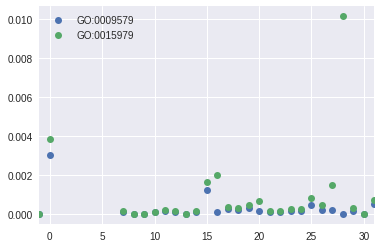

,GO:0009579,GO:0015979
-1,0.000000,0.000000
0,0.003037,0.003842
7,0.000102,0.000129
8,0.000000,0.000000
9,0.000000,0.000000
10,0.000077,0.000106
11,0.000135,0.000203
12,0.000097,0.000146
13,0.000000,0.000000
14,0.000121,0.000160


In [21]:
import matplotlib.pyplot as plt
from pandas import DataFrame

df = DataFrame(result).T.fillna(0)


df.plot(y=['GO:0009579', 'GO:0015979'], use_index=True, style='o')

plt.show()

df[['GO:0009579', 'GO:0015979']]

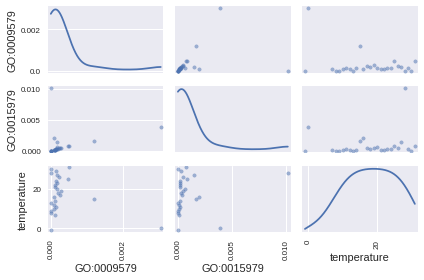

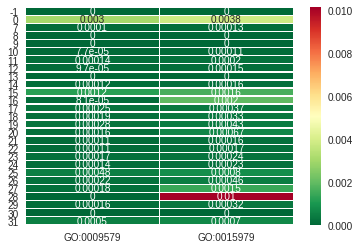

In [16]:
# plot correlated values
df['temperature'] = df.index
df[['GO:0009579', 'GO:0015979']].corr(method="spearman")

df[['GO:0009579', 'GO:0015979']].corr(method="kendall")

df[['GO:0009579', 'GO:0015979']].corr(method="pearson")

import pandas as pd
pd.tools.plotting.scatter_matrix(df[['GO:0009579', 'GO:0015979', 'temperature']], diagonal="kde")
plt.tight_layout()
plt.show()


import seaborn as sns
%matplotlib inline
sns.heatmap(df[['GO:0009579', 'GO:0015979']], cmap='RdYlGn_r', linewidths=0.5, annot=True)

### Calculate correlation

In [9]:
from scipy.stats import spearmanr
df = DataFrame(result).T.fillna(0)
x = df.index.tolist()
correl = []
correl_p = []
for k in df.keys():
    y = list(df[k])
    rho, p = spearmanr(x, y)

    correl.append(rho)
    correl_p.append(p)
df.loc['rho'] = correl
df.loc['p'] = correl_p

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [10]:
df[['GO:0009579','GO:0015979']]

,GO:0009579,GO:0015979
-1,0.000000,0.000000
0,0.003037,0.003842
7,0.000102,0.000129
8,0.000000,0.000000
9,0.000000,0.000000
10,0.000077,0.000106
11,0.000135,0.000203
12,0.000097,0.000146
13,0.000000,0.000000
14,0.000121,0.000160
